<a href="https://colab.research.google.com/github/JiHoonPark96/practice/blob/main/Classification_HW1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification Homework Section 1: Simulated Data

In this notebook, we will practice using several common classification techniques for binary data using [sklearn](http://scikit-learn.org).  You should use this notebook to gain some intuition about how each of these classification methods work, and how algorithm parameters affect classification performance.  

Feel free to edit this notebook, but note that you will be using this notebook to solve your homework problems.



This notebook is accompanied by two pickle files containing artificial datasets:

- `data_multigauss.p` <br>
- `data_spiral.p`

The data contained in these files has already been split into training and validation sets.  The files contain `(X_train, X_val, y_train, y_val)`  as numpy arrays.  

The data inputs `X_train` and `X_val` are 2-dimensional, making them convenient to visualize.  

The data outputs `y_train` and `y_val` contain binary class labels (0,1).

We provide several functions for visualizing the output of your classifiers.  You are encouraged to look at and edit these functions to get more familiar with matplotlib, but they should work without modification.

In [ ]:
# import
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pickle
import pandas as pd

# plot within the notebook
%matplotlib inline

# some plotting configurations
matplotlib.rcParams['figure.figsize'] = (10,10)
matplotlib.style.use('ggplot')
matplotlib.rcParams.update({'font.size': 16})

## Load and Visualize Data
Here we will visualize the training data.  Note that the data is noisy and is *not* linearly seperable.

Your options for `datafile` are `'data_multigauss.p'` and `'data_spiral.p'`.

In [ ]:
# Load the data
datafile = 'data_multigauss.p'
X_train, X_val, y_train, y_val = pickle.load( open(datafile , 'rb' ) )

feature_names = ['x_{}'.format(k) for k in range(len(X_train[0,:]))]

# Store training and validation data in pandas dataframes
data_train = pd.DataFrame(np.c_[X_train, y_train],columns= np.append(feature_names, ['y']))
data_val = pd.DataFrame(np.c_[X_val, y_val],columns= np.append(feature_names, ['y']))

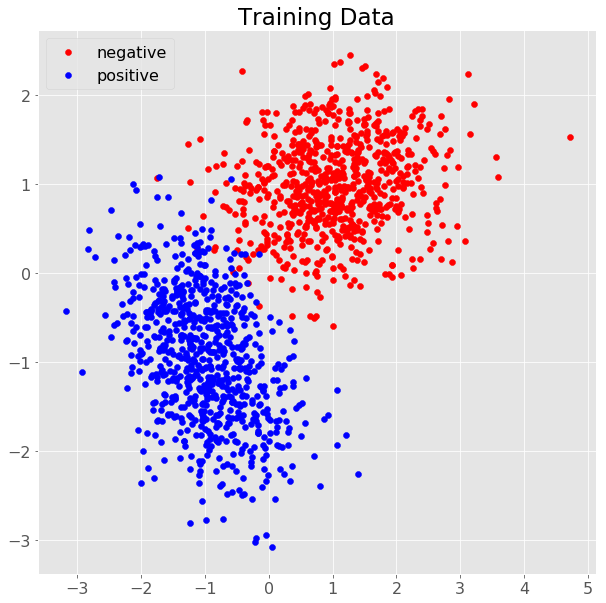

In [ ]:
# Plot the training data

Xneg = data_train[data_train['y']==0]
Xpos = data_train[data_train['y']==1]

plt.figure(figsize=(10, 10))
plt.scatter(Xneg['x_0'],Xneg['x_1'],color='r',label='negative')
plt.scatter(Xpos['x_0'],Xpos['x_1'],color='b',label='positive')
plt.legend()
plt.title('Training Data')

## Functions for training a generic sklearn classifier and plotting the results

Here we provide some functions you may find helpful for training, evaluating and visualizing your classifiers.  You are encouraged to look at these functions to understand what they're doing, but they should work without modification.

The function `train_and_plot()` takes in a sklearn classifier object, fits the model to training data, and evaluates the model on validation data.  This particular function assumes 2D data (defined by features x0_col and x1_col) and binary class labels (y = 0 or 1).

The function `plot_data_class()` will create a 2D plot of data that has gone through a classifier.  If the original data (and therefore the classifier decision boundary) is also in 2D, it will also plot the decision boundary.

In [ ]:
def plot_data_class(data, x0_col=None, x1_col=None, xx=None, yy=None, Z=None, title='Classification Results'):
    """
    Plot the classification results on data and the decision boundary
    (Decision boundary will only be plotted if data is 2D)


    Parameters
    ----------
    data :  pandas dataframe with columns = 'x_0', 'x_1', ... 'x_n', 'y', 'y_predict'
            each row corresponds to a single data point
                column 'x_n'       : nth feature
                column 'y'         : true data label
                column 'y_predict' : predicted data label

    x0_col: string corresponding to the x-axis feature
    x1_col: string corresponding to the y-axis feature

    xx :    nd-array containing x-axis values for contour plot, must correspond to x0_col feature in data
    yy :    nd-array containing y-axis values for contour plot, must correspond to x1_col feature in data
            xx, yy = np.meshgrid()

    Z :     nd-array corresponding to classifier predictions of (xx,yy)
            Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
            Z = Z.reshape(xx.shape)

    title :  title of the plot (optional, default: 'Classification Results')

    Returns
    -------
    None

    """

    # data features (exclude labels and predicted labels, if stored in the dataframe)
    features = data.columns.difference(['y','y_predict'])

    # If no features are specified, use the first two
    if x0_col is None: x0_col = features[0]
    if x1_col is None: x1_col = features[1]

    # Separate the data into correctly and incorrectly classified sets
    TP = data[(data['y']==1) & (data['y_predict']==1)]   # true positives
    FP = data[(data['y']==0) & (data['y_predict']==1)]   # false positives (type I error)
    TN = data[(data['y']==0) & (data['y_predict']==0)]   # true negatives
    FN = data[(data['y']==1) & (data['y_predict']==0)]   # false negatives (type II error)

    # Plot the contours if we're able (will pass if xx, yy, or Z are None)
    try: plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu,alpha=0.5)
    except: pass

    # Plot the datapoints in 2D (actual data may be in higher dimension)
    plt.scatter(TP[x0_col],TP[x1_col],marker='.',c='b',label='TP')
    plt.scatter(TN[x0_col],TN[x1_col],marker='.',c='r',label='TN')
    plt.scatter(FN[x0_col],FN[x1_col],marker='x',c='b',s=100,label='FN')
    plt.scatter(FP[x0_col],FP[x1_col],marker='x',c='r',s=100,label='FP')

    plt.xlabel(x0_col)
    plt.ylabel(x1_col)
    plt.legend()
    plt.title(title)


In [ ]:
def train_and_plot(clf, data_train, data_test, plot_bool=True, x0_col=None, x1_col=None):

    """
    Train a classifier, evaluate, and plot

    Parameters
    ----------

    clf  :  a sklearn classifier object (e.g., sklearn.neighbors)

    data_train : pandas dataframe containing 2D training data
                 each row corresponds to a single data point
                        column 'y' : true label

    data_test :  pandas dataframe containing 2D test data
                 each row corresponds to a single data point
                        column 'y' : true label

    plot_bool :  boolean (default: True)
                 set to False to suppress plots

    x0_col :     name of first feature to plot, corresponding to a column in data_train
                 if x0_col is not specified, the first column is used

    x1_col :     name of second feature to plot, corresponding to a column in data_train
                 if x1_col is not specified, the second column is used


    Returns
    -------
    acc :   dictionary
                'acc_train' : training accuracy
                'acc_test'  : testing accuracy

    """


    # Define X (exclude labels and predicted labels, if stored in the dataframe)
    X_train = data_train[data_train.columns.difference(['y','y_predict'])]
    X_test = data_test[data_test.columns.difference(['y','y_predict'])]

    # Train (fit) the classifier to training data
    clf = clf.fit(X_train,data_train['y'])

    # Apply the classifier to train and test data
    data_train['y_predict'] = clf.predict(X_train)
    data_test['y_predict'] = clf.predict(X_test)

    # Calculate train and test accuracy
    acc_train = clf.score(X_train,data_train['y'])
    acc_test = clf.score(X_test,data_test['y'])


    # Plot the classification
    if plot_bool:

        if x0_col is None: x0_col = X_train.columns[0]
        if x1_col is None: x1_col = X_train.columns[1]


        # If we only have 2 features, we can make a contour plot by evaluating over a grid!  Otherwise, skip.
        if X_train.shape[1] == 2:

            x_min = min(X_train[x0_col].min(),X_test[x0_col].min()) - 0.2
            x_max = max(X_train[x0_col].max(),X_test[x0_col].max()) + 0.2
            y_min = min(X_train[x1_col].min(),X_test[x1_col].min()) - 0.2
            y_max = max(X_train[x1_col].max(),X_test[x1_col].max()) + 0.2

            plot_step_x = (x_max-x_min)/100
            plot_step_y = (y_max-y_min)/100
            xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step_x),np.arange(y_min, y_max, plot_step_y))

            # Predict on grid for contour plot
            Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
            Z = Z.reshape(xx.shape)
        else:
            xx,yy,Z=None,None,None

        # Plot
        plt.figure(figsize=(20, 10))
        plt.subplot(1, 2, 1)
        plot_data_class(data_train, x0_col, x1_col, xx, yy, Z, title='Train Data, acc={:0.3f}'.format(acc_train))
        plt.subplot(1, 2, 2)
        plot_data_class(data_test, x0_col, x1_col, xx, yy, Z, title='Test Data, acc={:0.3f}'.format(acc_test))
        plt.show()



    return {'acc_train':acc_train, 'acc_test':acc_test}

# Train a Naive Bayes Classifier
Refer to scikit-learn documentation for details: [Gaussian Naive Bayes Classifier](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html)

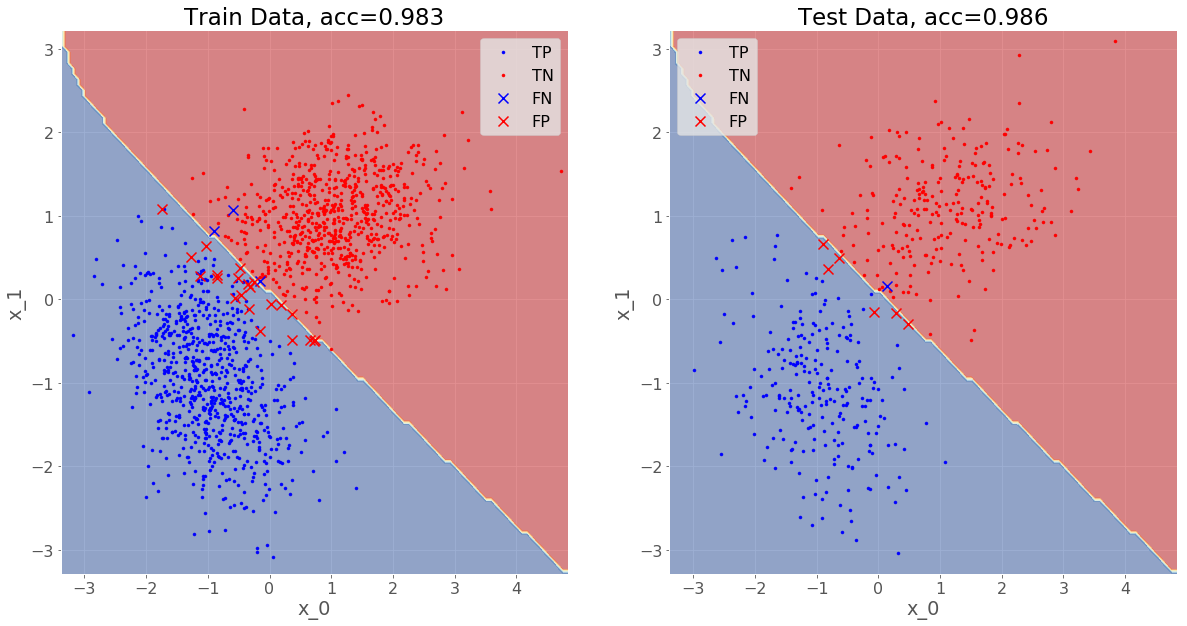

Training Accuracy: 0.983
Testing Accuracy:  0.986


In [ ]:
from sklearn import naive_bayes

# Define the classifier
priors=None
clf = naive_bayes.GaussianNB(priors=priors)


# Train the classifier and plot
acc = train_and_plot(clf, data_train, data_val, plot_bool=True)

# Print accuracy values
print('Training Accuracy: {:0.3f}'.format(acc['acc_train']))
print('Testing Accuracy:  {:0.3f}'.format(acc['acc_test']))

### HW 1.1: Naive Bayes Priors
If you do not define the prior for the Naive Bayes classifier (`priors=None`), what is the calculated probability of the negative class?

> *Hint*: use `clf.class_prior_[0]` to see the negative class prior or `clf.class_prior_[1]` to see the positive class prior

In [ ]:
# Student code goes here




### HW 1.2: Naive Bayes Training Accuracy
What is the value of `prior_0` that results in the highest accuracy on the **training** data for the Naive Bayes classifier?


> *Note*: Test priors in `np.linspace(0.1,0.9,num=9)`.<br>
> *Note*: Make sure to report the value of parameter `prior_0`, not the accuracy

In [ ]:
for prior_0 in np.linspace(0.1,0.9,num=9):

    # Student code goes here




### HW 1.3: Naive Bayes Test Accuracy
What is the **test** accuracy achieved by the Naive Bayes Classifier using the value of `prior_0` from the previous question?

> *Note*: `acc = train_and_plot(...)` returns `acc`, a dictionary containing the training and testing accuracy on the data sets provided.  Try `print(acc)` to print the contents of this dictionary, or `print(acc['acc_test'])` to print only the test accuracy.

In [ ]:
# Student code goes here




# Train a k-NN Classifier
Refer to scikit-learn documentation for details: [Nearest Neighbors Classifier](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)

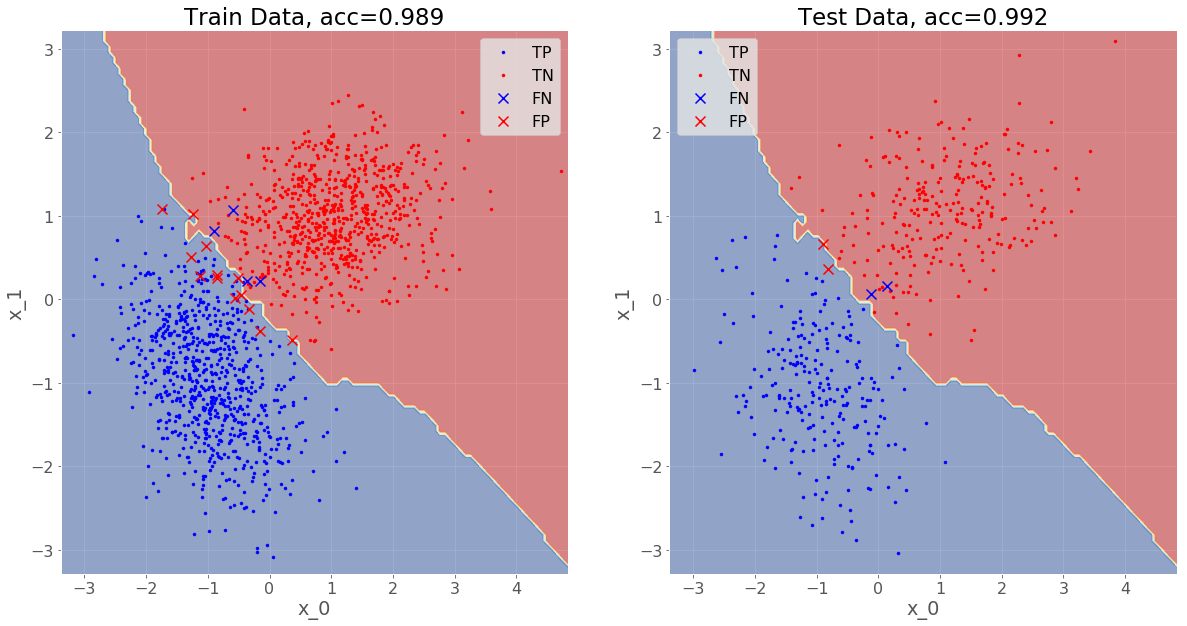

Training Accuracy: 0.989
Testing Accuracy:  0.992


In [ ]:
from sklearn import neighbors

# Define the classifier
n_neighbors = 5
clf = neighbors.KNeighborsClassifier(n_neighbors=n_neighbors)

# Train the classifier and plot
acc = train_and_plot(clf, data_train, data_val, plot_bool=True)

# Print accuracy values
print('Training Accuracy: {:0.3f}'.format(acc['acc_train']))
print('Testing Accuracy:  {:0.3f}'.format(acc['acc_test']))

### HW 1.4: Nearest Neighbors
What is the value of `n` that results in the highest accuracy on the **validation** (or test) data for the Nearest Neighbors classifier?
Test `n in range(1,21)`. If there are multiple values of `n` that give the same accuracy, report the smallest `n`.

In [ ]:
for n in range(1,21):

    # Student code goes here




# Train a Decision Tree
Refer to scikit-learn documentation for details: [Decision Tree Classifier](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)


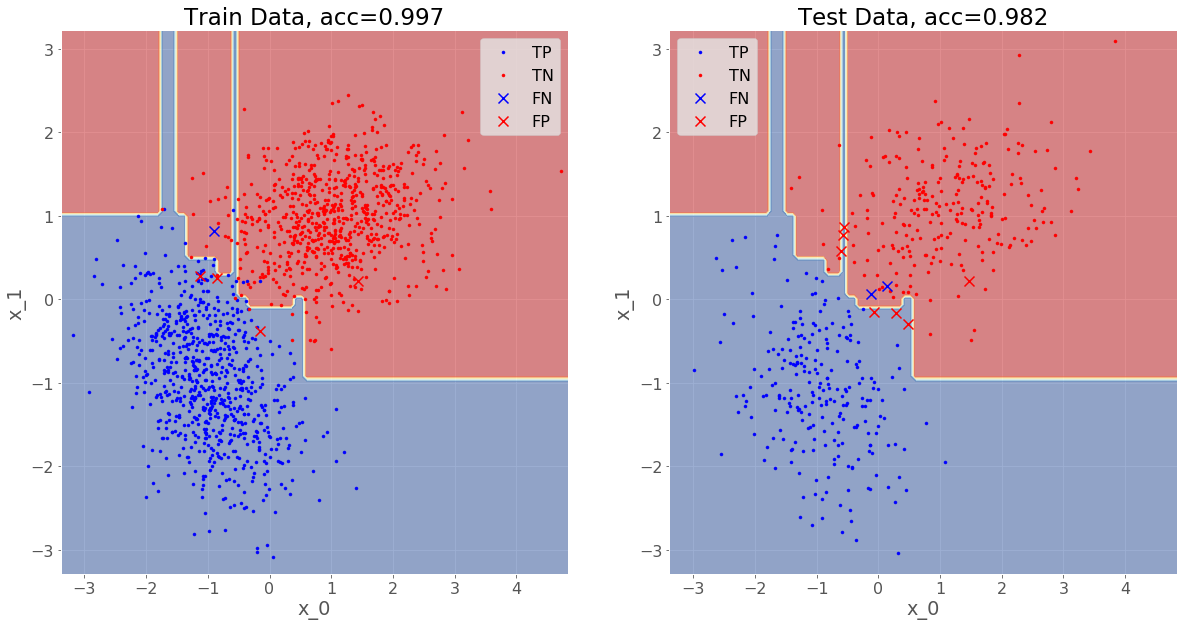

Training Accuracy: 0.997
Testing Accuracy:  0.982


In [ ]:
from sklearn import tree

# Define the classifier
max_depth = 5
clf = tree.DecisionTreeClassifier(max_depth=max_depth, random_state=999)

# Train the classifier and plot
acc = train_and_plot(clf, data_train, data_val, plot_bool=True)

# Print accuracy values
print('Training Accuracy: {:0.3f}'.format(acc['acc_train']))
print('Testing Accuracy:  {:0.3f}'.format(acc['acc_test']))

### HW 1.5: Decision Tree Training
What is the value of `max_depth` that results in the highest accuracy on the **training** data for the Decision Tree classifier?

### HW 1.6: Decision Tree Testing
What is the value of `max_depth` that results in the highest accuracy on the **validation** (test) data for the Decision Tree classifier?

> Note: Test `max_depth in range(1,16)`. If there are multiple values of `max_depth` that give the same accuracy, report the smallest `max_depth`.

In [ ]:
for max_depth in range(1,16):

    # Student code goes here




# Train a Linear Support Vector Machine
Refer to scikit-learn documentation for details: [SVM Classifier](http://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html)


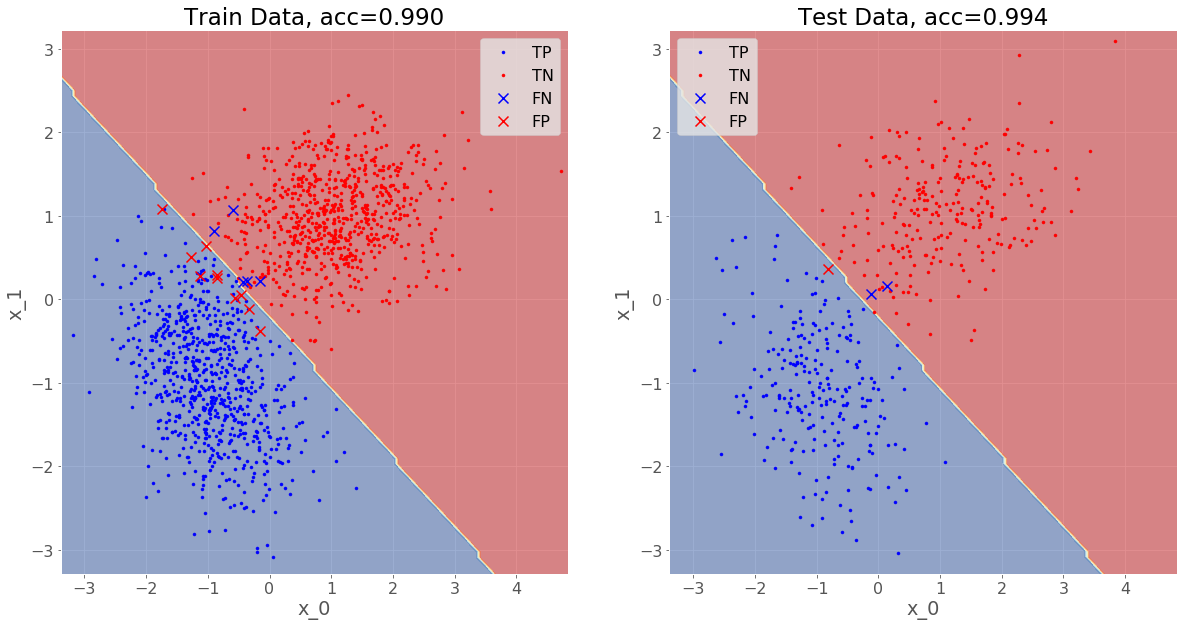

Training Accuracy: 0.990
Testing Accuracy:  0.994


In [ ]:
from sklearn import svm

# Define the classifier
C=1.0
clf = svm.LinearSVC(C=C, random_state=999)

# Train the classifier and plot
acc = train_and_plot(clf, data_train, data_val, plot_bool=True)

# Print accuracy values
print('Training Accuracy: {:0.3f}'.format(acc['acc_train']))
print('Testing Accuracy:  {:0.3f}'.format(acc['acc_test']))

# Train a Support Vector Machine with Kernels
Refer to scikit-learn documentation for details: [SVM Classifier](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)


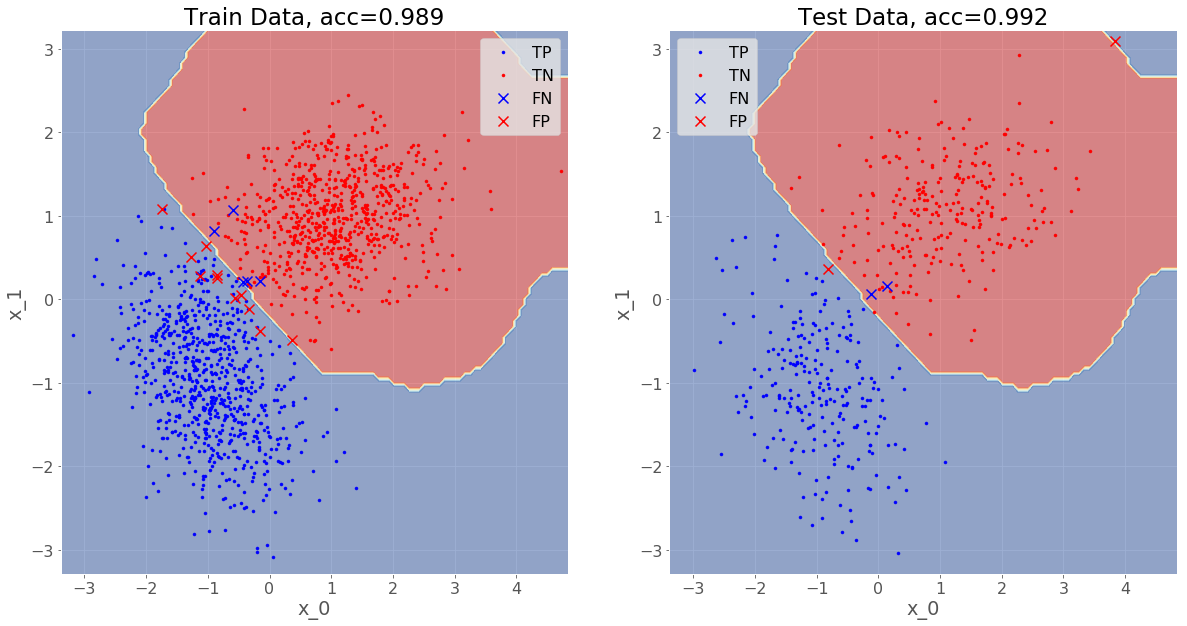

Training Accuracy: 0.989
Testing Accuracy:  0.992


In [ ]:
from sklearn import svm

# Classifier parameters
kernel = 'rbf'
gamma = 3
C = 1.0

# Define the classifier
clf = svm.SVC(kernel=kernel, C=C, gamma=gamma, random_state=999)

# Train the classifier and plot
acc = train_and_plot(clf, data_train, data_val, plot_bool=True)

# Print accuracy values
print('Training Accuracy: {:0.3f}'.format(acc['acc_train']))
print('Testing Accuracy:  {:0.3f}'.format(acc['acc_test']))

### HW 1.7: SVM Training
What is the value of `gamma` that results in the highest accuracy on the **training** data for the SVM classifier using an RBF kernel?

### HW 1.8: SVM Testing
What is the value of `gamma` that results in the highest accuracy on the **validation** (test) data for the SVM classifier using an RBF kernel?

> Test `gamma in range(1,31)`. If there are multiple values of `gamma` that give the same accuracy, report the smallest `gamma`.

In [ ]:
for gamma in range(1,31):

    # Student code goes here


